In [47]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [49]:
# Load the dataset
covid = pd.read_csv('P:\COVID-19 Outbreak Prediction\datasets\covid.csv')
covid.head(5)
# covid.to_string()

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,...,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k
0,ABW,Aruba,2020-03-13,2,2,0,0,18.733,18.733,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
1,ABW,Aruba,2020-03-20,4,2,0,0,37.465,18.733,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
2,ABW,Aruba,2020-03-24,12,8,0,0,112.395,74.930,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
3,ABW,Aruba,2020-03-25,17,5,0,0,159.227,46.831,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
4,ABW,Aruba,2020-03-26,19,2,0,0,177.959,18.733,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN


In [50]:
all_columns = covid.columns
print(all_columns)

Index(['iso_code', 'location', 'date', 'total_cases', 'new_cases',
       'total_deaths', 'new_deaths', 'total_cases_per_million',
       'new_cases_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_units',
       'stringency_index', 'population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cvd_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_100k'],
      dtype='object')


In [51]:
print(covid.shape)
print(covid.info())

(19496, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19496 entries, 0 to 19495
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   iso_code                         19432 non-null  object 
 1   location                         19496 non-null  object 
 2   date                             19496 non-null  object 
 3   total_cases                      19496 non-null  int64  
 4   new_cases                        19496 non-null  int64  
 5   total_deaths                     19496 non-null  int64  
 6   new_deaths                       19496 non-null  int64  
 7   total_cases_per_million          19119 non-null  float64
 8   new_cases_per_million            19119 non-null  float64
 9   total_deaths_per_million         19119 non-null  float64
 10  new_deaths_per_million           19119 non-null  float64
 11  total_tests                      5164 non-null   float64
 12  new_te

In [52]:
covid.isnull().sum().to_frame(name="Missing Count").assign(Percentage=lambda x: (x["Missing Count"] / len(covid)) * 100)

,Missing Count,Percentage
iso_code,64,0.328272
location,0,0.000000
date,0,0.000000
total_cases,0,0.000000
new_cases,0,0.000000
total_deaths,0,0.000000
new_deaths,0,0.000000
total_cases_per_million,377,1.933730
new_cases_per_million,377,1.933730
total_deaths_per_million,377,1.933730


In [53]:
import pandas as pd
import numpy as np

# Create a copy of the DataFrame to preserve the original data
covid = covid.copy()

# Define a dictionary of imputation strategies for each column with missing values.
# You can adjust these strategies based on domain knowledge.
impute_strategy = {
    'iso_code': 'mode',
    'total_cases_per_million': 'mean',
    'new_cases_per_million': 'mean',
    'total_deaths_per_million': 'mean',
    'new_deaths_per_million': 'mean',
    'total_tests': 'median',
    'new_tests': 'median',
    'total_tests_per_thousand': 'median',
    'new_tests_per_thousand': 'median',
    'new_tests_smoothed': 'median',
    'new_tests_smoothed_per_thousand': 'median',
    'tests_units': 'mode',
    'stringency_index': 'mean',
    'population': 'mean',
    'population_density': 'mean',
    'median_age': 'mean',
    'aged_65_older': 'mean',
    'aged_70_older': 'mean',
    'gdp_per_capita': 'mean',
    'extreme_poverty': 'median',
    'cvd_death_rate': 'mean',
    'diabetes_prevalence': 'mean',
    'female_smokers': 'mean',
    'male_smokers': 'mean',
    'handwashing_facilities': 'median',
    'hospital_beds_per_100k': 'mean'
}

# Iterate over each column in the dictionary and impute missing values
for col, strategy in impute_strategy.items():
    # Determine the imputation value based on the strategy
    if strategy == 'mean':
        imputed_value = covid[col].mean()
    elif strategy == 'median':
        imputed_value = covid[col].median()
    elif strategy == 'mode':
        imputed_value = covid[col].mode()[0]
    else:
        continue  # If no valid strategy is provided, skip
    
    # For integer columns, round the value and convert the column to int after imputation
    if pd.api.types.is_integer_dtype(covid[col]):
        imputed_value = int(round(imputed_value))
        covid[col] = covid[col].fillna(imputed_value).astype(int)
    else:
        covid[col] = covid[col].fillna(imputed_value)

# Optional: Print the missing value counts after preprocessing for verification
print(covid[list(impute_strategy.keys())].isnull().sum())

iso_code                           0
total_cases_per_million            0
new_cases_per_million              0
total_deaths_per_million           0
new_deaths_per_million             0
total_tests                        0
new_tests                          0
total_tests_per_thousand           0
new_tests_per_thousand             0
new_tests_smoothed                 0
new_tests_smoothed_per_thousand    0
tests_units                        0
stringency_index                   0
population                         0
population_density                 0
median_age                         0
aged_65_older                      0
aged_70_older                      0
gdp_per_capita                     0
extreme_poverty                    0
cvd_death_rate                     0
diabetes_prevalence                0
female_smokers                     0
male_smokers                       0
handwashing_facilities             0
hospital_beds_per_100k             0
dtype: int64


In [54]:
# Convert date column to datetime format
covid["date"] = pd.to_datetime(covid["date"])

In [55]:
# Handling missing values
covid.fillna(method='ffill', inplace=True)

C:\Users\BAISAMPAYAN\AppData\Local\Temp\ipykernel_24036\2381037643.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  covid.fillna(method='ffill', inplace=True)


In [56]:
# Basic EDA
print("Dataset Shape:", covid.shape)
print("Dataset Info:")
print(covid.info())
print("Summary Statistics:")
print(covid.describe())

Dataset Shape: (19496, 32)
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19496 entries, 0 to 19495
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   iso_code                         19496 non-null  object        
 1   location                         19496 non-null  object        
 2   date                             19496 non-null  datetime64[ns]
 3   total_cases                      19496 non-null  int64         
 4   new_cases                        19496 non-null  int64         
 5   total_deaths                     19496 non-null  int64         
 6   new_deaths                       19496 non-null  int64         
 7   total_cases_per_million          19496 non-null  float64       
 8   new_cases_per_million            19496 non-null  float64       
 9   total_deaths_per_million         19496 non-null  float64       
 10  new_deaths_per_mi

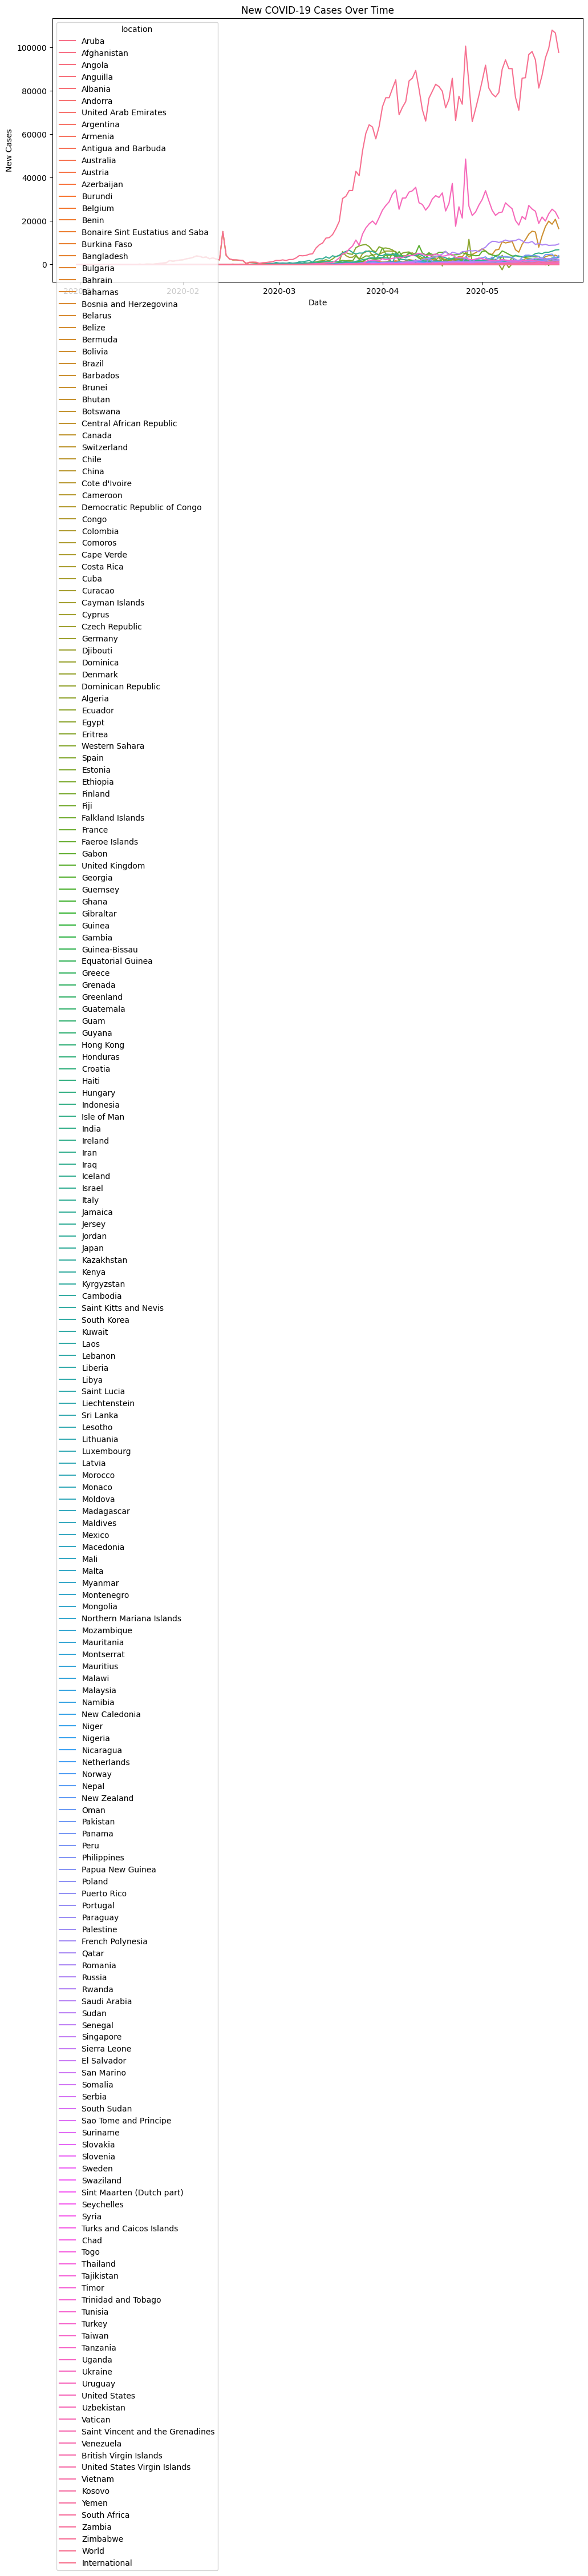

In [57]:
# Plot new cases over time
plt.figure(figsize=(12,6))
sns.lineplot(data=covid, x="date", y="new_cases", hue="location")
plt.title("New COVID-19 Cases Over Time")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.show()

In [58]:
# Feature Engineering: Creating rolling average
covid['new_cases_avg'] = covid['new_cases'].rolling(window=7).mean()

In [59]:
# Normalize data for LSTM model
scaler = MinMaxScaler()
covid[['total_cases', 'total_deaths', 'total_tests', 'population', 'new_cases']] = scaler.fit_transform(
    covid[['total_cases', 'total_deaths', 'total_tests', 'population', 'new_cases']]
)

In [60]:
# Prepare data for LSTM
features = ['total_cases', 'total_deaths', 'total_tests', 'population']
target = 'new_cases'

data = covid[features].values
target_data = covid[target].values.reshape(-1, 1)

X, y = [], []
seq_length = 10

for i in range(len(data) - seq_length):
    X.append(data[i:i+seq_length])
    y.append(target_data[i+seq_length])

X, y = np.array(X), np.array(y)

In [61]:
covid.isnull().sum().to_frame(name="Missing Count").assign(Percentage=lambda x: (x["Missing Count"] / len(covid)) * 100)

,Missing Count,Percentage
iso_code,0,0.000000
location,0,0.000000
date,0,0.000000
total_cases,0,0.000000
new_cases,0,0.000000
total_deaths,0,0.000000
new_deaths,0,0.000000
total_cases_per_million,0,0.000000
new_cases_per_million,0,0.000000
total_deaths_per_million,0,0.000000


In [62]:
# Basic EDA
print("Dataset Shape:", covid.shape)
print("Dataset Info:")
print(covid.info())
print("Summary Statistics:")
print(covid.describe())

Dataset Shape: (19496, 33)
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19496 entries, 0 to 19495
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   iso_code                         19496 non-null  object        
 1   location                         19496 non-null  object        
 2   date                             19496 non-null  datetime64[ns]
 3   total_cases                      19496 non-null  float64       
 4   new_cases                        19496 non-null  float64       
 5   total_deaths                     19496 non-null  float64       
 6   new_deaths                       19496 non-null  int64         
 7   total_cases_per_million          19496 non-null  float64       
 8   new_cases_per_million            19496 non-null  float64       
 9   total_deaths_per_million         19496 non-null  float64       
 10  new_deaths_per_mi

In [63]:
import pandas as pd
import numpy as np

# Create a copy of the DataFrame to preserve the original data
covid = covid.copy()

# Define the imputation strategy for 'new_cases_avg'
impute_strategy = 'mean'  # You can change this to 'median' or 'mode' if needed

# Determine the imputed value
if impute_strategy == 'mean':
    imputed_value = covid['new_cases_avg'].mean()
elif impute_strategy == 'median':
    imputed_value = covid['new_cases_avg'].median()
elif impute_strategy == 'mode':
    imputed_value = covid['new_cases_avg'].mode()[0]
else:
    raise ValueError("Invalid imputation strategy")

# Fill missing values in 'new_cases_avg'
covid['new_cases_avg'] = covid['new_cases_avg'].fillna(imputed_value)

# Verify that missing values are handled
print("Missing values in 'new_cases_avg':", covid['new_cases_avg'].isnull().sum())

Missing values in 'new_cases_avg': 0


In [64]:
covid.isnull().sum().to_frame(name="Missing Count").assign(Percentage=lambda x: (x["Missing Count"] / len(covid)) * 100)

,Missing Count,Percentage
iso_code,0,0.0
location,0,0.0
date,0,0.0
total_cases,0,0.0
new_cases,0,0.0
total_deaths,0,0.0
new_deaths,0,0.0
total_cases_per_million,0,0.0
new_cases_per_million,0,0.0
total_deaths_per_million,0,0.0


In [65]:
# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
# Build LSTM Model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

c:\Users\BAISAMPAYAN\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [67]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0013 - val_loss: 5.6505e-04
Epoch 2/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 7.7815e-04 - val_loss: 3.8177e-04
Epoch 3/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.7956e-04 - val_loss: 2.7159e-04
Epoch 4/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.3693e-04 - val_loss: 2.1452e-04
Epoch 5/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 2.8994e-04 - val_loss: 2.7955e-04
Epoch 6/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 6.5925e-04 - val_loss: 1.8626e-04
Epoch 7/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.0256e-04 - val_loss: 1.7202e-04
Epoch 8/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.2331e-04 - val_loss: 1.9373e-04
Epoch 9/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.6187e-04 - val_loss: 2.9323e-04
Epoch 10/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.9721e-04 - val_loss: 3.1750e-04
Epoch 11/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.

In [68]:
# Predictions
y_pred = model.predict(X_test)

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [69]:
# Model evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")


Mean Absolute Error: 0.0036218328363025807
Mean Squared Error: 0.00010797222830642334
Root Mean Squared Error: 0.010390968593274803


In [70]:
# Save the trained model
model.save('models/covid_lstm_model.h5')


In [71]:
import keras
keras.saving.save_model(model, 'models/my_model.keras')

In [76]:
import pickle
import os

# Create models directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# Save the fitted MinMaxScaler
with open("models/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("✅ MinMaxScaler saved as 'P:\COVID-19 Outbreak Prediction\models/scaler.pkl'")


✅ MinMaxScaler saved as 'P:\COVID-19 Outbreak Prediction\models/scaler.pkl'


In [77]:
# One scaler for features
feature_scaler = MinMaxScaler()
covid[features] = feature_scaler.fit_transform(covid[features])

# One scaler only for target (new_cases)
target_scaler = MinMaxScaler()
covid[[target]] = target_scaler.fit_transform(covid[[target]])

# Save only the target scaler
with open("models/scaler.pkl", "wb") as f:
    pickle.dump(target_scaler, f)
